In [17]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import sys
sys.path.append('..')
import networks
from utils import *
from networks import *

In [18]:
import matplotlib.pyplot as plt
import scienceplots
import cmasher as cmr
plt.style.use('science')
cmap_pred = plt.get_cmap('cmr.wildfire')
cmap_error = plt.get_cmap('cmr.cosmic')

In [19]:
problem = "kdv"
running_on = "local"
if running_on == "local":
    data_path = "C:/Users/eirik/OneDrive - NTNU/5. klasse/prosjektoppgave/eirik_prosjektoppgave/data/"
    checkpoint_path = "C:/Users/eirik/orbax/checkpoints/"
else:
    data_path = "/cluster/work/eirikaf/data/"
    checkpoint_path = "/cluster/work/eirikaf/checkpoints/"

In [20]:
data = jnp.load(data_path + problem + ".npz")
train_val_test = train_val_test_split(data["data"], 0.8, 0.1, 0.1)
scaled_data = jnp.load(data_path + problem + "_z_score.npz")

In [21]:
u_standardizer = GaussianStandardizer(train_val_test["train"])
x_standardizer = GaussianStandardizer(data["x"])
t_standardizer = GaussianStandardizer(data["t"])

In [22]:
a_train_s = scaled_data["a_train_s"]
u_train_s = scaled_data["u_train_s"]
a_val_s = scaled_data["a_val_s"]
u_val_s = scaled_data["u_val_s"]
a_test_s = scaled_data["a_test_s"]
u_test_s = scaled_data["u_test_s"]

x_train_s = scaled_data["x_train_s"]
t_train_s = scaled_data["t_train_s"]

x_test_s = scaled_data["x_test_s"] 
t_test_s = scaled_data["t_test_s"]

x_test = x_standardizer.decode(x_test_s)
t_test = t_standardizer.decode(t_test_s)

u_test = u_standardizer.decode(u_test_s)

In [23]:
pretty_names = {
    "deeponet_new": "DeepONet",
    "modified_deeponet_new": "ModifiedDeepONet",
    "fno_timestepping_new": "FNOTimeStepping",
    "fno1d_new": "FNO1d",
    "fno2d_new": "FNO2d"
}

networks = {
    "deeponet_new": DeepONet,
    "modified_deeponet_new": ModifiedDeepONet,
    "fno_timestepping_new": FNOTimeStepping,
    "fno1d_new": FNO1d,
    "fno2d_new": FNO2d
}

In [24]:
models = {}
trainers = {}

for network_name, network in networks.items():
    try:
        trainers[network_name] = Trainer.from_checkpoint(checkpoint_path + f"{network_name}_{problem}", 
                                                    network)
        models[network_name] = trainers[network_name].model
    except:
        print(f"Failed to load {network_name}")
        continue

### Plot one prediction from the test set for t = 0, t $\approx$ 1, t $\approx$ 2, t $\approx$ 3

In [25]:
from traditional_solvers import Dx

In [26]:
sample_idx = 88

u_preds = {}
u_t_preds = {}
u_x_preds = {}
u_preds_FD_t = {}
u_preds_FD_x = {}
for network_name, model in models.items():
    if network_name != "fno2d":
        """
        To extrapolate, we use the solution at t=2 as the initial condition for the next time interval [2, 4).
        """
        t = t_test_s[t_test<=2] # time interval [0, 2]
        # prediction on [0, 2]
        u_pred1_s = model.predict_whole_grid(a_test_s[sample_idx], x_test_s, t)
        u_t_pred1 = model.u_t_whole_grid(a_test_s[sample_idx], x_test_s, t)
        u_x_pred1 = model.u_x_whole_grid(a_test_s[sample_idx], x_test_s, t)
        # prediction on [2, 4) by using the last prediction (at t=2) as initial condition
        u_pred2_s = model.predict_whole_grid(u_pred1_s[-1], x_test_s, t)
        u_t_pred2 = model.u_t_whole_grid(u_pred1_s[-1], x_test_s, t)
        u_x_pred2 = model.u_x_whole_grid(u_pred1_s[-1], x_test_s, t)
        
        # concatenate the predictions on [0, 2) and [2, 3), making sure not to include the overlapping time point twice
        u_preds[network_name] = model.decode_u(jnp.concatenate((u_pred1_s, u_pred2_s[1:]), axis=0))[:len(t_test)]
        u_t_preds[network_name] = (jnp.concatenate((u_t_pred1, u_t_pred2[1:]), axis=0))[:len(t_test)]
        u_x_preds[network_name] = (jnp.concatenate((u_x_pred1, u_x_pred2[1:]), axis=0))[:len(t_test)]
        
        # finite difference of the predictions
        u_preds_FD_x[network_name] = Dx(u_preds[network_name], x_test[1], axis = 1)
        u_preds_FD_t[network_name] = Dx(u_preds[network_name], t_test[1], axis = 0)
    elif network_name == "fno2d":
        """
        To extrapolate, we use the solution at t~2 as the initial condition for the next time interval [~2, 4).
        """
        t = t_test_s[t_test < 2] # time interval [0, 2)
        # prediction on [0, 2)
        u_pred1_s = model.predict_whole_grid(a_test_s[sample_idx], x_test_s, t)
        u_t_pred1 = model.u_t_whole_grid(a_test_s[sample_idx], x_test_s, t)
        u_x_pred1 = model.u_x_whole_grid(a_test_s[sample_idx], x_test_s, t)
        # prediction on [~2, 4) by using the last prediction (at t~2) as initial condition
        u_pred2_s = model.predict_whole_grid(u_pred1_s[-1], x_test_s, t)
        u_t_pred2 = model.u_t_whole_grid(u_pred1_s[-1], x_test_s, t)
        u_x_pred2 = model.u_x_whole_grid(u_pred1_s[-1], x_test_s, t)
        
        # concatenate the predictions on [0, 2) and [~2, 4), making sure not to include the overlapping time point twice
        u_preds[network_name] = model.decode_u(jnp.concatenate((u_pred1_s, u_pred2_s[1:]), axis=0))[:len(t_test)]
        u_t_preds[network_name] = (jnp.concatenate((u_t_pred1, u_t_pred2[1:]), axis=0))[:len(t_test)]
        u_x_preds[network_name] = (jnp.concatenate((u_x_pred1, u_x_pred2[1:]), axis=0))[:len(t_test)]
        
        # finite difference of the predictions
        u_preds_FD_x[network_name] = Dx(u_preds[network_name], x_test[1], axis = 1)
        u_preds_FD_t[network_name] = Dx(u_preds[network_name], t_test[1], axis = 0)
    else:
        """
        To extrapolate, we use the same initial condition with higher time points.
        """
        u_preds[network_name] = model.decode_u(model.predict_whole_grid(a_test_s[sample_idx], x_test_s, t_test_s))
        u_t_preds[network_name] = model.u_t_whole_grid(a_test_s[sample_idx], x_test_s, t_test_s)
        u_x_preds[network_name] = model.u_x_whole_grid(a_test_s[sample_idx], x_test_s, t_test_s)
        
        # finite difference of the predictions
        u_preds_FD_x[network_name] = Dx(u_preds[network_name], x_test[1], axis = 1)
        u_preds_FD_t[network_name] = Dx(u_preds[network_name], t_test[1], axis = 0)

In [27]:
u_gt = u_test[sample_idx]
u_t_FD = Dx(u_gt, t_test[1], axis = 0)[3:-3]
u_x_FD = Dx(u_gt, x_test[1], axis = 1)

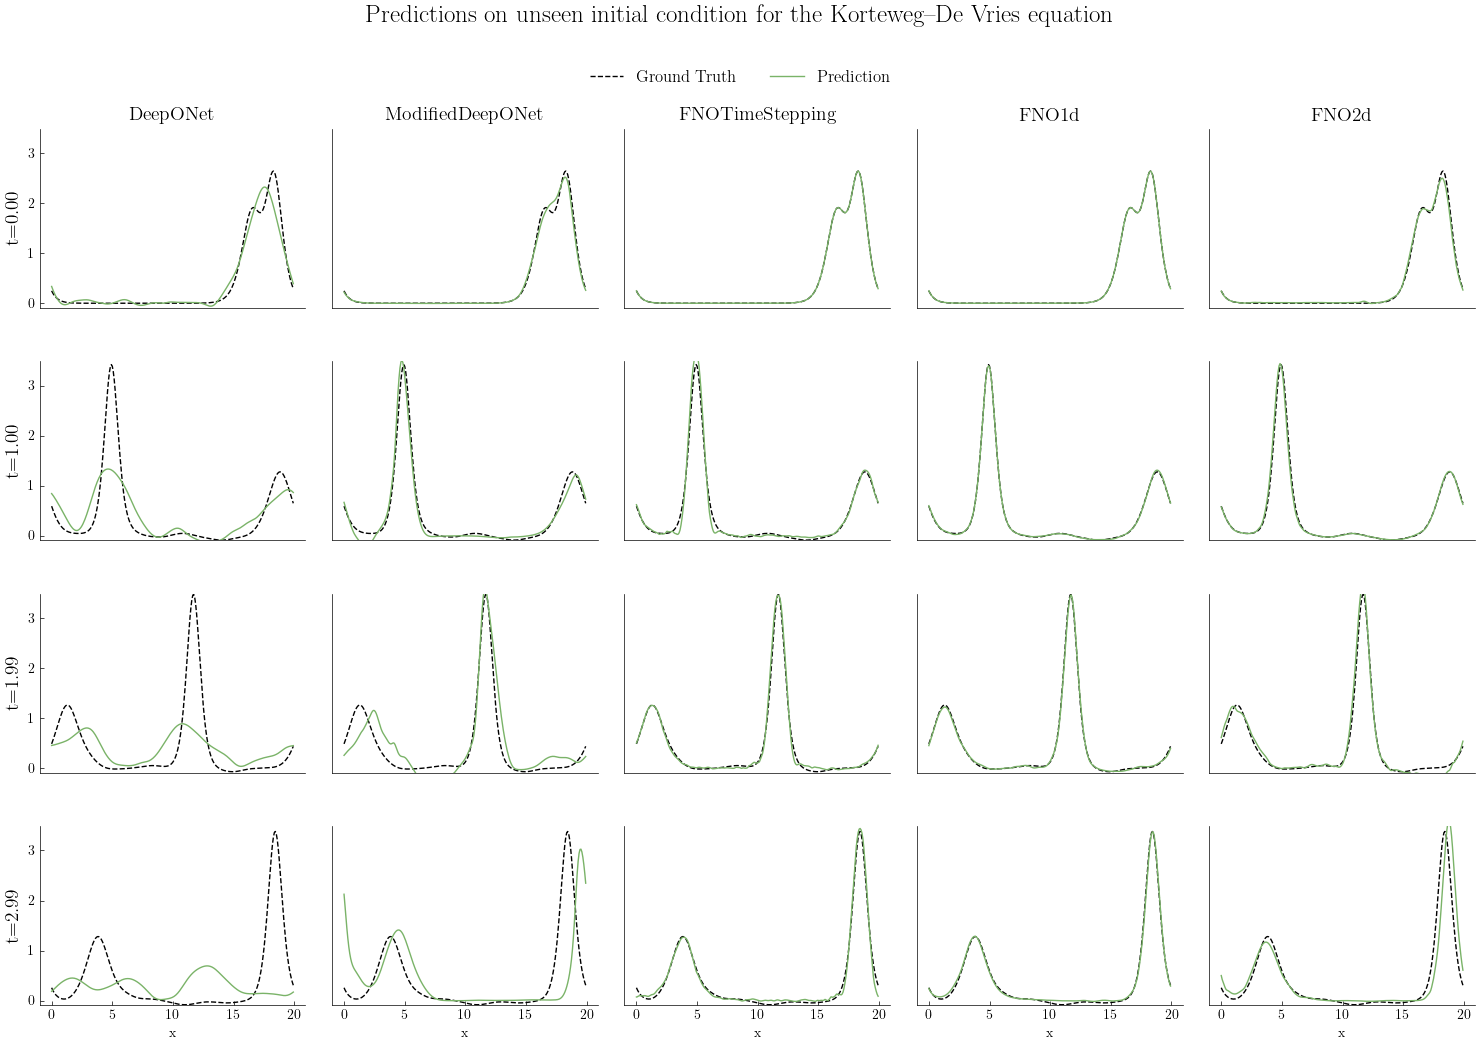

In [28]:
pred_color = "#7ab368"

time_indices = [0, jnp.where(t_test == 1)[0][0], jnp.where(t_test < 2)[0][-1], -1]
time_labels = [f't={t_test[time_indices[0]]:.2f}', f't={t_test[time_indices[1]]:.2f}', f't={t_test[time_indices[2]]:.2f}', f't={t_test[time_indices[3]]:.2f}']

fig, axes = plt.subplots(len(time_indices), len(u_preds), figsize=(15, 10))

y_min, y_max = u_gt.min(), u_gt.max()
for i, time_idx in enumerate(time_indices):
    for j, (model_name, u_pred) in enumerate(u_preds.items()):
        ax = axes[i, j]
        ax.plot(x_test, u_gt[time_idx, :], 'k--', label='Ground Truth')
        ax.plot(x_test, u_pred[time_idx, :], color=pred_color, label='Prediction')
        ax.set_ylim(y_min, y_max)  # Set the y-axis limits
        
        ax.tick_params(top=False,
                left=False,
                right=False, 
                bottom=False, 
                labelleft=False, 
                labelbottom=False, 
                which='both')
                
        if i == 0:
            ax.set_title(pretty_names[model_name], fontsize=14)
        if j == 0:
            ax.set_ylabel(time_labels[i], fontsize=14)
            ax.tick_params(left=True, labelleft=True)
        if i == len(time_indices) - 1:
            ax.set_xlabel('x')
            ax.tick_params(bottom=True, labelbottom=True)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

# Create a common legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.), fontsize='large')

# Add a title to the figure
fig.suptitle('Predictions on unseen initial condition for the Korteweg–De Vries equation', fontsize=18, x=0.5, y=1.05)

# Adjust space between subplots
plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.3)

plt.savefig("predictions/pred_kdv.svg")
plt.show()

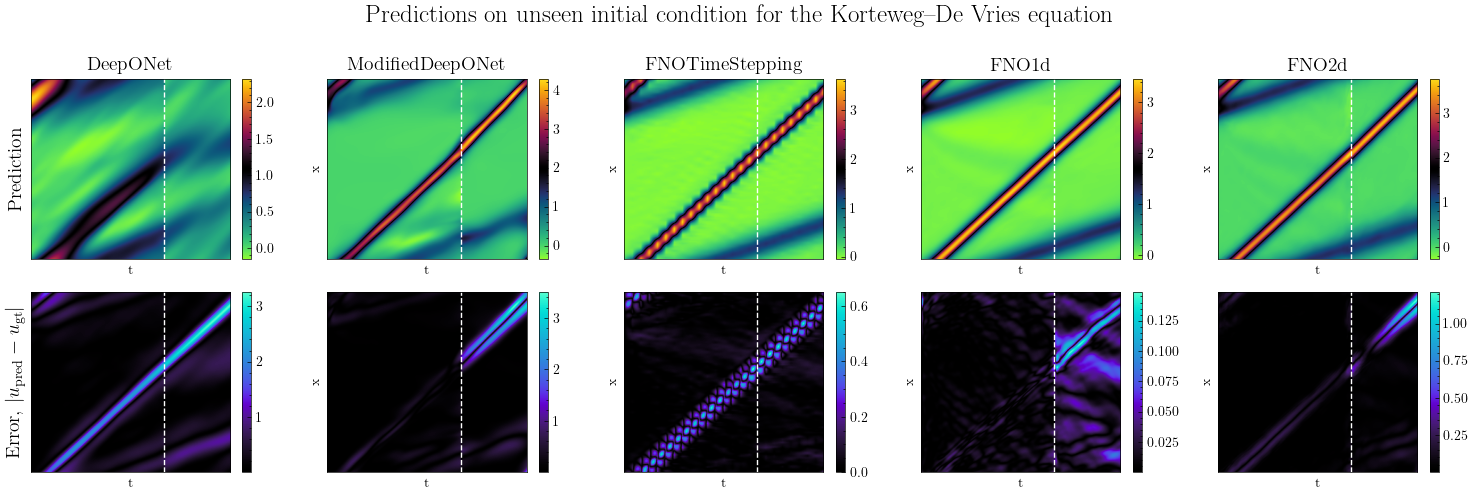

In [29]:
fig, axes = plt.subplots(2, len(u_preds), figsize=(15, 5))

for i, (model_name, u_pred) in enumerate(u_preds.items()):
    # First row: imshow of u_pred
    ax1 = axes[0, i]
    im1 = ax1.imshow(u_pred.T, aspect='auto', cmap=cmap_pred, extent=[t_test.min(), t_test.max(), x_test.min(), x_test.max()], origin='lower')
    ax1.set_title(pretty_names[model_name], fontsize=14)
    fig.colorbar(im1, ax=ax1)
    ax1.set_xlabel('t')
    ax1.set_ylabel('x')
    ax1.axvline(x=2, color='white', linestyle='--')  # Add dashed line for t_test == 2
    ax1.tick_params(
                top=False,
                right=False, 
                bottom=False, 
                left=False,
                labelleft=False, 
                labelbottom=False, 
                which='both')
    
    # Second row: imshow of u_pred - u_gt
    ax2 = axes[1, i]
    im2 = ax2.imshow(jnp.abs(u_pred - u_gt).T, aspect='auto', cmap=cmap_error, extent=[t_test.min(), t_test.max(), x_test.min(), x_test.max()], origin='lower')
    fig.colorbar(im2, ax=ax2)
    ax2.set_xlabel('t')
    ax2.set_ylabel('x')
    ax2.axvline(x=2, color='white', linestyle='--')
    ax2.tick_params(
            top=False,
            right=False, 
            bottom=False, 
            left=False,
            labelleft=False, 
            labelbottom=False, 
            which='both')

axes[0, 0].set_ylabel('Prediction', fontsize=14)
axes[1, 0].set_ylabel(r'Error, $|u_{\text{pred}} - u_{\text{gt}}|$', fontsize=14)

fig.suptitle('Predictions on unseen initial condition for the Korteweg–De Vries equation', fontsize=18, x=0.5, y=1)

plt.tight_layout()
plt.savefig("predictions/pred_kdv_imshow.svg")
plt.show()

# Spatial derivatives

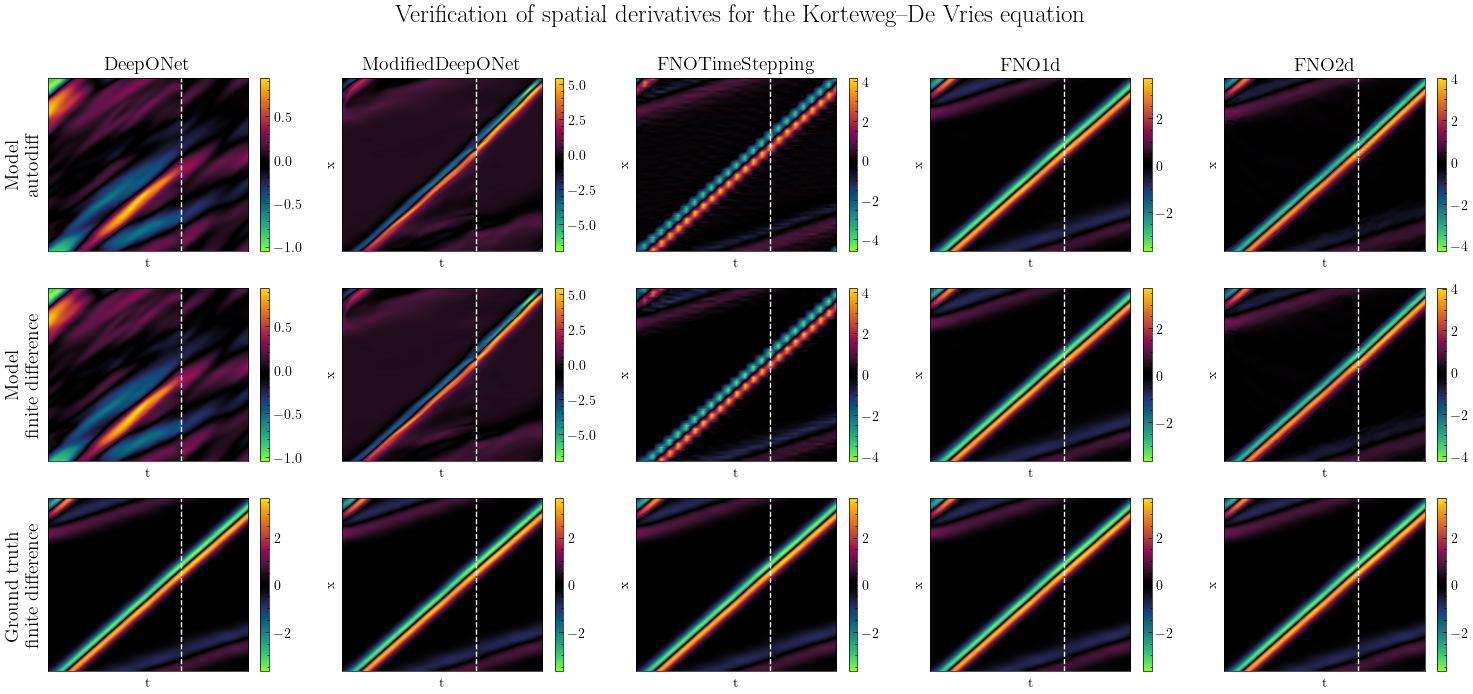

In [30]:
fig, axes = plt.subplots(3, len(u_x_preds), figsize=(15, 7))

for i, (model_name, u_x_pred) in enumerate(u_x_preds.items()):
    # First row: imshow of u_x_pred
    ax1 = axes[0, i]
    im1 = ax1.imshow(u_x_pred.T, aspect='auto', cmap=cmap_pred, extent=[t_test.min(), t_test.max(), x_test.min(), x_test.max()], origin='lower')
    ax1.set_title(pretty_names[model_name], fontsize=14)
    fig.colorbar(im1, ax=ax1)
    ax1.set_xlabel('t')
    ax1.set_ylabel('x')
    ax1.axvline(x=2, color='white', linestyle='--')  # Add dashed line for t_test == 2
    ax1.tick_params(
                top=False,
                right=False, 
                bottom=False, 
                left=False,
                labelleft=False, 
                labelbottom=False, 
                which='both')
    
    # Second row: imshow of u_preds_FD_x
    ax2 = axes[1, i]
    im2 = ax2.imshow(u_preds_FD_x[model_name].T, aspect='auto', cmap=cmap_pred, extent=[t_test.min(), t_test.max(), x_test.min(), x_test.max()], origin='lower')
    fig.colorbar(im2, ax=ax2)
    ax2.set_xlabel('t')
    ax2.set_ylabel('x')
    ax2.axvline(x=2, color='white', linestyle='--')
    ax2.tick_params(
            top=False,
            right=False, 
            bottom=False, 
            left=False,
            labelleft=False, 
            labelbottom=False, 
            which='both')

    # Third row: imshow of u_x_FD
    ax3 = axes[2, i]
    im3 = ax3.imshow(u_x_FD.T, aspect='auto', cmap=cmap_pred, extent=[t_test.min(), t_test.max(), x_test.min(), x_test.max()], origin='lower')
    fig.colorbar(im3, ax=ax3)
    ax3.set_xlabel('t')
    ax3.set_ylabel('x')
    ax3.axvline(x=2, color='white', linestyle='--')
    ax3.tick_params(
            top=False,
            right=False, 
            bottom=False, 
            left=False,
            labelleft=False, 
            labelbottom=False, 
            which='both')

axes[0, 0].set_ylabel('Model\nautodiff', fontsize=14)
axes[1, 0].set_ylabel('Model\nfinite difference', fontsize=14)
axes[2, 0].set_ylabel('Ground truth\nfinite difference', fontsize=14)

fig.suptitle('Verification of spatial derivatives for the Korteweg–De Vries equation', fontsize=18, x=0.5, y=1)

plt.tight_layout()
plt.savefig("other/spatial_derivatives_kdv.svg")
plt.show()

# Time derivatives

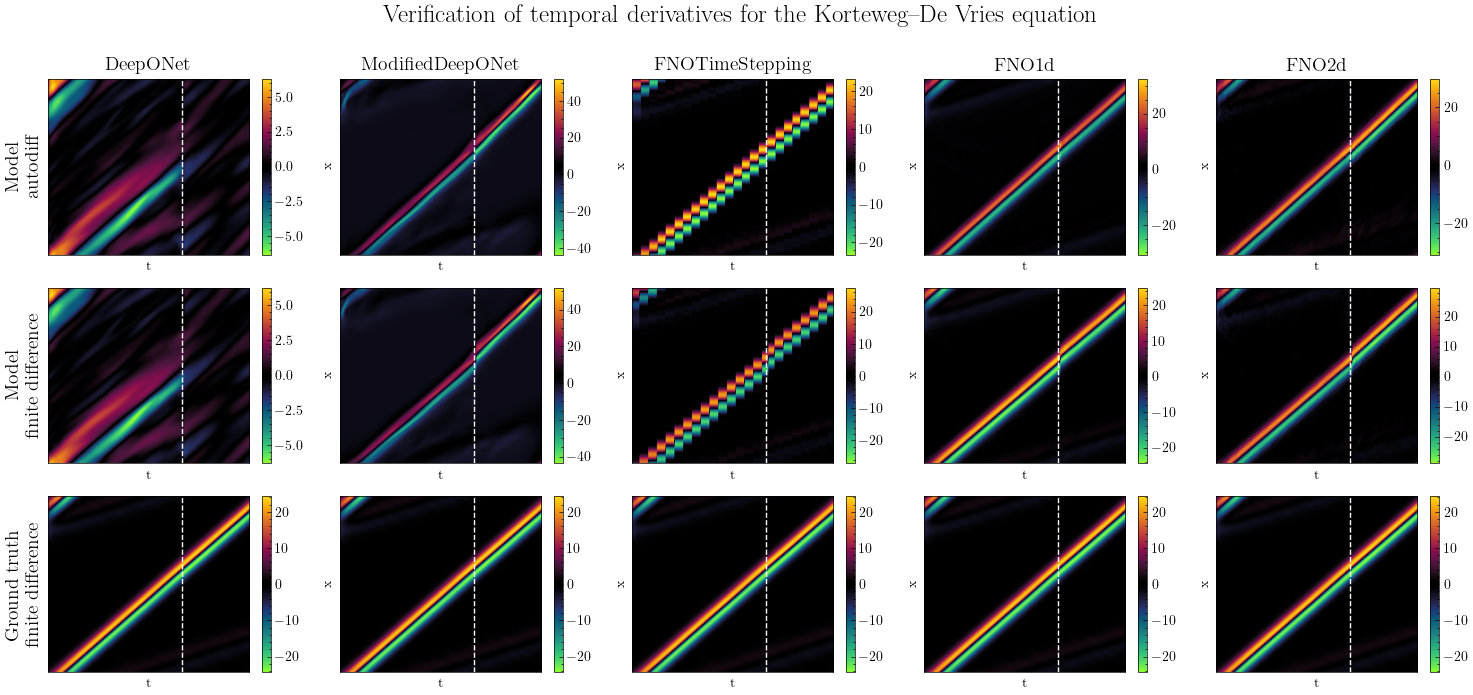

In [31]:
fig, axes = plt.subplots(3, len(u_t_preds), figsize=(15, 7))

target_idx = jnp.where(t_test == 2)[0][0]
exclude_range = jnp.arange(max(0, target_idx - 4), min(len(t_test), target_idx + 5))
include_mask = ~jnp.isin(jnp.arange(len(t_test)), exclude_range)

for i, (model_name, u_t_pred) in enumerate(u_t_preds.items()):
    # First row: imshow of u_pred
    ax1 = axes[0, i]
    im1 = ax1.imshow(u_t_pred.T, aspect='auto', cmap=cmap_pred, extent=[t_test.min(), t_test.max(), x_test.min(), x_test.max()], origin='lower')
    ax1.set_title(pretty_names[model_name], fontsize=14)
    fig.colorbar(im1, ax=ax1)
    ax1.set_xlabel('t')
    ax1.set_ylabel('x')
    ax1.axvline(x=2, color='white', linestyle='--')  # Add dashed line for t_test == 2
    ax1.tick_params(
                top=False,
                right=False, 
                bottom=False, 
                left=False,
                labelleft=False, 
                labelbottom=False, 
                which='both')
    
    # Second row: fininte difference of u_t
    ax2 = axes[1, i]
    im2 = ax2.imshow(u_preds_FD_t[model_name][include_mask][3:-3].T, aspect='auto', cmap=cmap_pred, extent=[t_test.min(), t_test.max(), x_test.min(), x_test.max()], origin='lower')
    fig.colorbar(im2, ax=ax2)
    ax2.set_xlabel('t')
    ax2.set_ylabel('x')
    ax2.axvline(x=2, color='white', linestyle='--')
    ax2.tick_params(
            top=False,
            right=False, 
            bottom=False, 
            left=False,
            labelleft=False, 
            labelbottom=False, 
            which='both')
    
        # Third row: imshow of u_x_FD
    ax3 = axes[2, i]
    im3 = ax3.imshow(u_t_FD.T, aspect='auto', cmap=cmap_pred, extent=[t_test.min(), t_test.max(), x_test.min(), x_test.max()], origin='lower')
    fig.colorbar(im3, ax=ax3)
    ax3.set_xlabel('t')
    ax3.set_ylabel('x')
    ax3.axvline(x=2, color='white', linestyle='--')
    ax3.tick_params(
            top=False,
            right=False, 
            bottom=False, 
            left=False,
            labelleft=False, 
            labelbottom=False, 
            which='both')

axes[0, 0].set_ylabel('Model\nautodiff', fontsize=14)
axes[1, 0].set_ylabel('Model\nfinite difference', fontsize=14)
axes[2, 0].set_ylabel('Ground truth\nfinite difference', fontsize=14)

fig.suptitle('Verification of temporal derivatives for the Korteweg–De Vries equation', fontsize=18, x=0.5, y=1)

plt.tight_layout()
plt.savefig("other/temporal_derivatives_kdv.svg")
plt.show()

# Loss plot

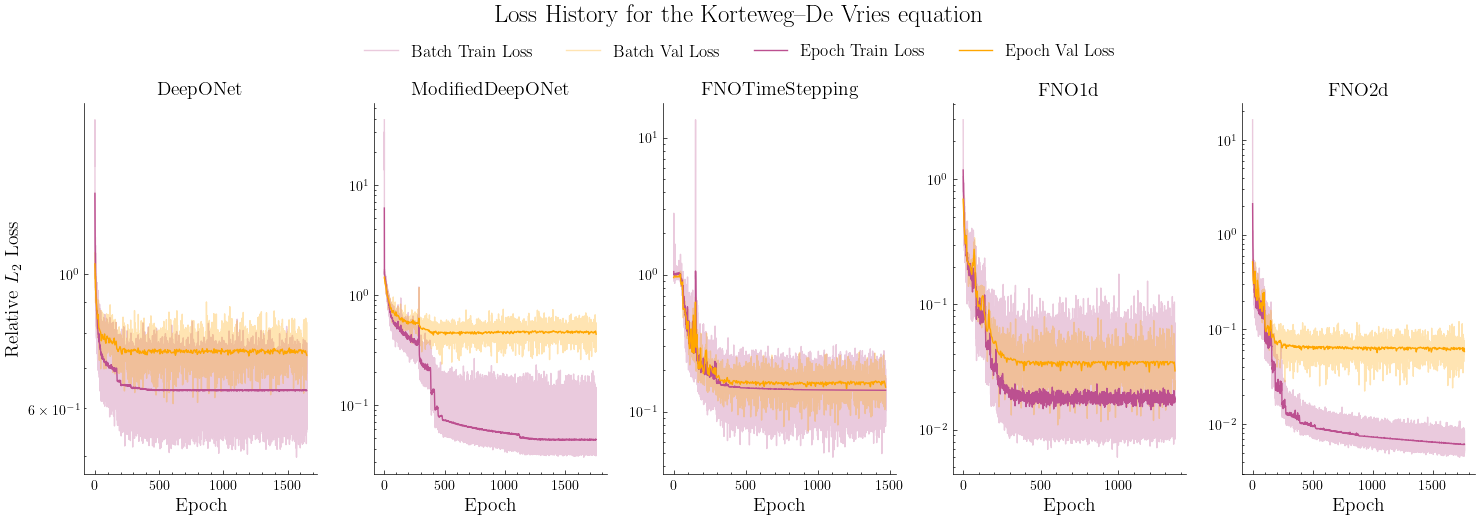

In [32]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
methods = list(trainers.keys())
train_color = '#bc5090'
val_color = '#ffa600'

for i, (model_name, trainer) in enumerate(trainers.items()):
        ax = axes[i]
        
        # Plot batch loss
        ax.plot(jnp.linspace(0, trainer.epochs_trained - 1, len(trainer.train_loss_history_batch)),
                trainer.train_loss_history_batch, color=train_color, alpha=0.3, label='Batch Train Loss')
        ax.plot(jnp.linspace(0, trainer.epochs_trained - 1, len(trainer.val_loss_history_batch)),
                trainer.val_loss_history_batch, color=val_color, alpha=0.3, label='Batch Val Loss')
        
        # Plot epoch loss
        ax.plot(jnp.arange(len(trainer.train_loss_history)), trainer.train_loss_history, 
                color=train_color, label='Epoch Train Loss')
        ax.plot(jnp.linspace(0, trainer.epochs_trained - 1, len(trainer.val_loss_history)), 
                trainer.val_loss_history, 
                color=val_color, label='Epoch Val Loss')
        
        ax.set_title(pretty_names[model_name], fontsize=14)
        ax.set_xlabel('Epoch', fontsize=14)
        ax.set_yscale('log')
        ax.tick_params(
                top=False,
                right=False, 
                which='both')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
axes[0].set_ylabel(r'Relative $L_2$ Loss', fontsize=14)   

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.), fontsize='large')

fig.suptitle('Loss History for the Korteweg–De Vries equation', fontsize=18, x=0.5, y=1.05)
plt.tight_layout()
plt.savefig("loss/loss_kdv.svg")
plt.show()

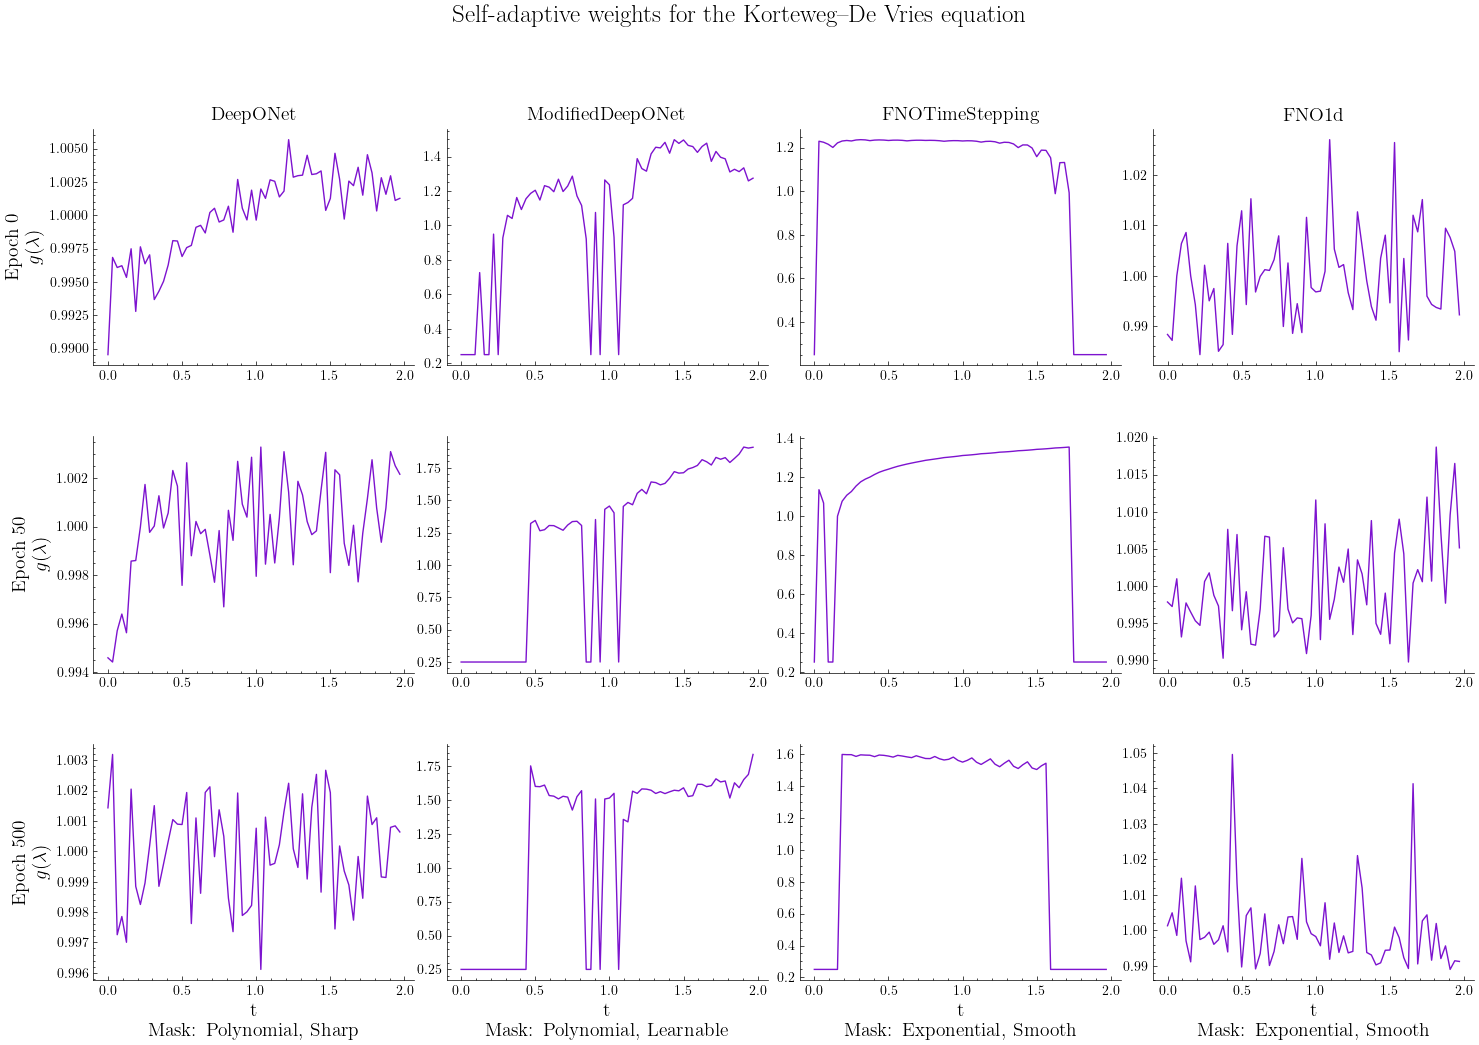

In [33]:
color = "#7d13cf"

fig, axes = plt.subplots(3, 4, figsize=(15, 10))

y_min, y_max = u_gt.min(), u_gt.max()
for j, (model_name, trainer) in enumerate(trainers.items()):
    if model_name != "fno2d_new":
        epochs = trainer.epochs_trained // 5
        λ_history = trainers[model_name].λ_history
        epoch_indices = [0, 10, 100]
        epoch_labels = [f'Epoch {epoch_indices[0]}\n'+r'$g(\lambda)$', f'Epoch {epoch_indices[1] * 5}\n'+r'$g(\lambda)$', f'Epoch {epoch_indices[2] * 5}\n'+r'$g(\lambda)$']
        for i, epoch_idx in enumerate(epoch_indices):
            ax = axes[i, j]
            ax.plot(t_standardizer.decode(t_train_s), λ_history[epoch_idx, 0, :], color=color)
            if i == 0:
                ax.set_title(pretty_names[model_name], fontsize=14)
            if i == 2:
                mask = trainer.hparams["λ_mask"].capitalize()
                learnable = trainer.hparams["λ_learnable"]
                smooth_or_sharp = trainer.hparams["λ_smooth_or_sharp"]
                if smooth_or_sharp is None: smooth_or_sharp = "Smooth"
                smooth_or_sharp = smooth_or_sharp.capitalize()
                type = "Learnable" if learnable else smooth_or_sharp
                ax.set_xlabel('t\n'+f'Mask: {mask}, {type}', fontsize=14)
            if j == 0:
                ax.set_ylabel(epoch_labels[i], fontsize=14)
            ax.tick_params(top=False,
                           right=False,
                           which='both')
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

# Create a common legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.), fontsize='large')

# Add a title to the figure
fig.suptitle('Self-adaptive weights for the Korteweg–De Vries equation', fontsize=18, x=0.5, y=1.05)

# Adjust space between subplots
plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.3)

plt.savefig("other/self_adaptive_kdv.svg")
plt.show()

# Table with performance information

In [34]:
def test_rel_lp(u_pred, u_test, p=2):    
    batch_size = len(u_test) 
    u_norms = jnp.linalg.norm(u_test.reshape(batch_size,-1), p, 1)
    diff_norms = jnp.linalg.norm((u_test - u_pred).reshape(batch_size,-1), p, 1)
        
    loss = jnp.mean(diff_norms/u_norms)
    return loss

In [35]:
from time import perf_counter

In [36]:
def time_prediction(model, a, x, t):
    start_time = perf_counter()
    u_pred = model.predict_whole_grid(a, x, t)
    elapsed_time = perf_counter() - start_time
    return elapsed_time

In [ ]:
# Initialize lists to store the results
method_names = []
param_counts = []
epochs_trained = []
rel_l2_errors = []
rel_l1_errors = []
time_predictions = []

t = t_test_s[t_test < 2]
u_test_without_extrapolation = u_test[:,t_test < 2]
# Iterate over each method and compute the required metrics
for method_name, trainer in trainers.items():    
    model = models[method_name]
    method_names.append(pretty_names[method_name])
    param_counts.append(param_count(model))
    epochs_trained.append(trainer.epochs_trained)
    
    #warmup
    jit_predict = eqx.filter_jit(model.predict_whole_grid)
    jit_predict(a_test_s, x_test_s, t)
    
    start_time = perf_counter()
    u_pred = jax.block_until_ready(model.decode_u(vmap(jit_predict, (0, None, None))(a_test_s, x_test_s, t)))
    elapsed_time = perf_counter() - start_time
    
    rel_l2_errors.append(test_rel_lp(u_pred, u_test_without_extrapolation, p=2))
    rel_l1_errors.append(test_rel_lp(u_pred, u_test_without_extrapolation, p=1))
    time_predictions.append(time_prediction(model, a_train_s[0], x_train_s, t_train_s))

# Create a pandas dataframe to store the results
results_df = pd.DataFrame({
    'Method': method_names,
    '# Parameters': param_counts,
    'Epochs Trained': epochs_trained,
    'Relative L2 Error': rel_l2_errors,
    'Relative L1 Error': rel_l1_errors,
    'Time Prediction (s)': time_predictions
})